In [107]:
import numpy as np
import pandas as pd
import datetime
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [108]:
df_train = pd.read_csv("../input/train.csv", usecols=["card_id", "feature_1", "feature_2", "feature_3", "target"])
df_test =  pd.read_csv("../input/test.csv", usecols=["card_id", "feature_1", "feature_2", "feature_3"])

In [109]:
df_train1 = pd.read_csv("../input/no_outlier_train_20190120.csv")
df_train1.columns = ["card_id", "predict_target_without_outliers"]

df_train2 = pd.read_csv("../input/target_train_20190120.csv")
df_train2.columns = ["card_id", "predict_target"]

df_train3 = pd.read_csv("../input/sign_clf_train_20190120.csv")

df_train4 = pd.read_csv("../input/outlier_clf_train_20180120.csv")

In [110]:
df_test1 = pd.read_csv("../input/no_outlier_test_20190120.csv")
df_test1.columns = ["card_id", "predict_target_without_outliers"]

df_test2 = pd.read_csv("../input/target_test_20190120.csv")
df_test2.columns = ["card_id", "predict_target"]

df_test3 = pd.read_csv("../input/sign_clf_test_20190120.csv")

df_test4 = pd.read_csv("../input/outlier_clf_test_20180120.csv")

In [111]:
df_train = pd.merge(df_train, df_train1, on="card_id", how="inner")
df_train = pd.merge(df_train, df_train2, on="card_id", how="inner")
df_train = pd.merge(df_train, df_train3, on="card_id", how="inner")
df_train = pd.merge(df_train, df_train4, on="card_id", how="inner")

In [112]:
df_test = pd.merge(df_test, df_test1, on="card_id", how="inner")
df_test = pd.merge(df_test, df_test2, on="card_id", how="inner")
df_test = pd.merge(df_test, df_test3, on="card_id", how="inner")
df_test = pd.merge(df_test, df_test4, on="card_id", how="inner")

In [113]:
dont_use =  ["card_id", "target"]
df_train_columns = [col for col in df_train.columns if col not in dont_use]

In [114]:
df_train["outliers"] = df_train.target.apply(lambda x:1 if x<-30 else 0)
target = df_train.target

In [115]:
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 20,
    'objective':'regression',
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.5,
    "bagging_freq": 1,
    "bagging_fraction": 0.5 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(target, oof))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.74495	valid_1's rmse: 3.75093
[200]	training's rmse: 3.68309	valid_1's rmse: 3.69293
[300]	training's rmse: 3.65023	valid_1's rmse: 3.66338
[400]	training's rmse: 3.6307	valid_1's rmse: 3.64719
[500]	training's rmse: 3.61862	valid_1's rmse: 3.63866
[600]	training's rmse: 3.61014	valid_1's rmse: 3.63399
[700]	training's rmse: 3.6038	valid_1's rmse: 3.63133
[800]	training's rmse: 3.59872	valid_1's rmse: 3.63057
[900]	training's rmse: 3.59406	valid_1's rmse: 3.63003
[1000]	training's rmse: 3.5902	valid_1's rmse: 3.62995
[1100]	training's rmse: 3.58642	valid_1's rmse: 3.6303
[1200]	training's rmse: 3.58273	valid_1's rmse: 3.63061
[1300]	training's rmse: 3.57899	valid_1's rmse: 3.63091
Early stopping, best iteration is:
[993]	training's rmse: 3.5905	valid_1's rmse: 3.62987
fold 1
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.74707	valid_1's rmse: 3.7428
[2

3.640556576994645

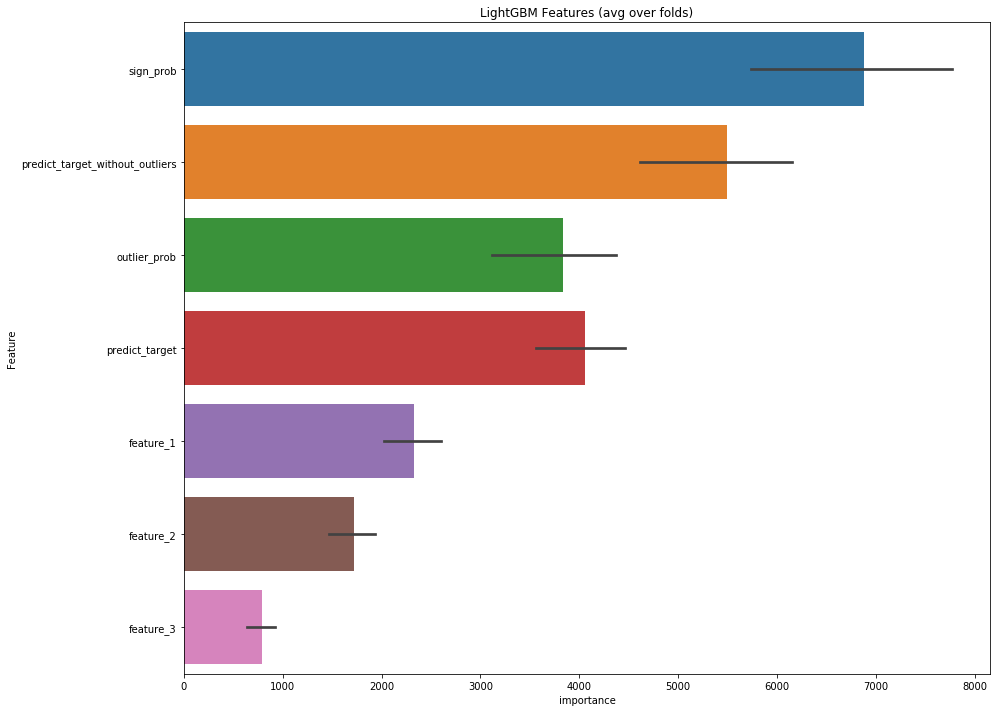

In [122]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [123]:
df_submission = pd.DataFrame({"card_id":df_test.card_id, "target":predictions})

In [124]:
outliers_idx = df_test4[df_test4.outlier_prob > 0.4].index.tolist()

In [125]:
df_submission["target"].iloc[outliers_idx] = -25

In [126]:
df_submission

,card_id,target
0,C_ID_0ab67a22ab,-2.021666
1,C_ID_130fd0cbdd,-0.333733
2,C_ID_b709037bc5,-0.990951
3,C_ID_d27d835a9f,-0.112749
4,C_ID_2b5e3df5c2,-1.549139
5,C_ID_5814b4f13c,0.297331
6,C_ID_a1b3c75277,0.083463
7,C_ID_f7cada36d3,0.463307
8,C_ID_9d2bc8dfc4,-0.631889
9,C_ID_6d8dba8475,-0.677143


In [127]:
df_submission.to_csv("../output/submission_2stage_model_20190120.csv", index=False)